In [ ]:

# import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.colors import LinearSegmentedColormap, Normalize
import matplotlib.colors as colors
from matplotlib.colors import ListedColormap, BoundaryNorm
import pandas as pd

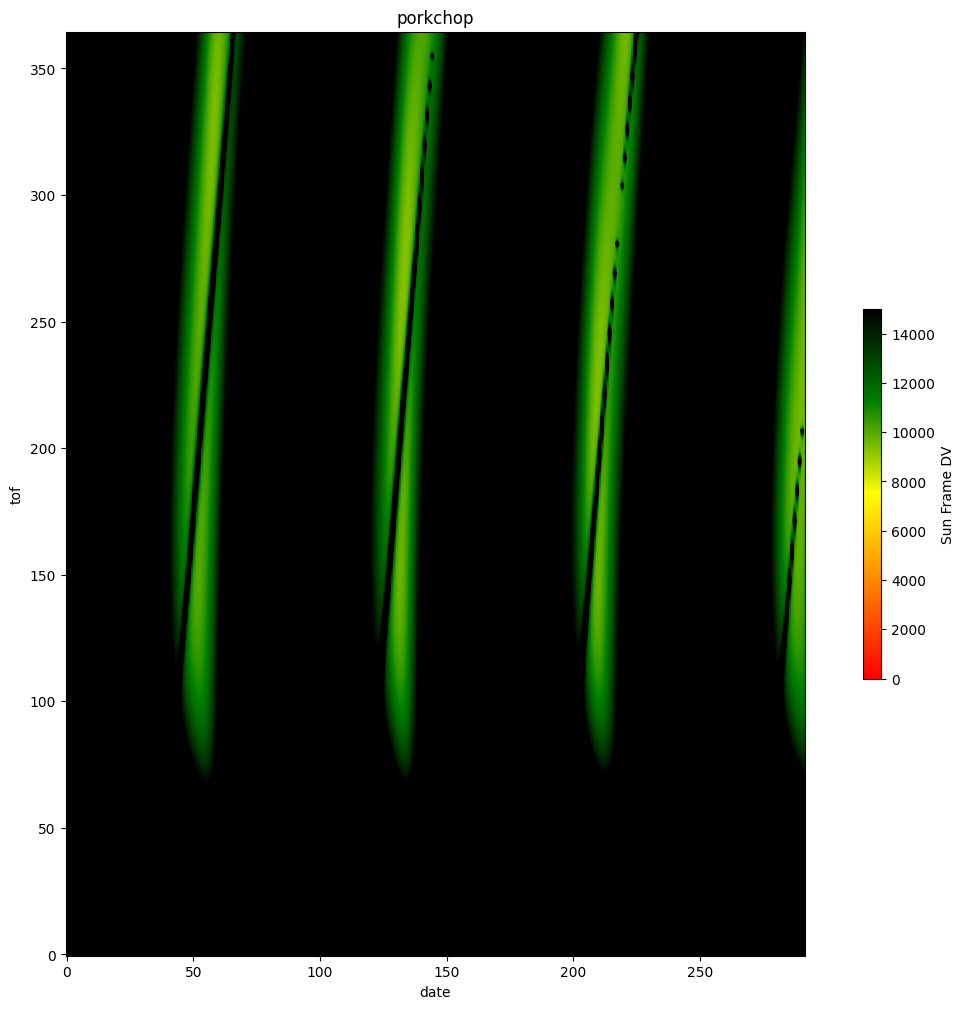

In [ ]:
dvs_mars = pd.read_csv('jupiter_dvs.csv', header=None).values
# dvs_jupiter = pd.read_csv('jupiter_dvs.csv', header=None).values
# dvs_saturn = pd.read_csv('saturn_dvs.csv', header=None).values
# test = np.array([[2,3],[3,4]])
# print(dvs_mars.values.shape)

#tof in units of 5 days, up from 0.25 yr to 5 yr

fig, ax = plt.subplots(figsize=(15, 12))
dv_stack = np.stack([dvs_mars], axis=0)  # shape (3, Ny, Nx)

# dv_stack = np.stack([dvs_mars, dvs_jupiter, dvs_saturn], axis=0)  # shape (3, Ny, Nx)


# Mask invalids so argmin ignores them
mask = np.isnan(dv_stack)
# Large filler so masked entries never win
dv_filled = np.where(mask, np.inf, dv_stack)


def step_cmap_rygk(cut1=4000, cut2=6000, cut3=8000,
                   labels=("red zone","yellow zone","green zone","black zone")):
    """
    Returns a step colormap & norm with 4 bins:
      (-inf, cut1] -> red
      (cut1, cut2] -> yellow
      (cut2, cut3] -> green
      (cut3, +inf) -> black

    labels: 4 strings for the colorbar tick labels (one per bin).
    """
    bounds = [-np.inf, float(cut1), float(cut2), float(cut3), np.inf]
    colors = ["red", "yellow", "green", "black"]
    cmap = ListedColormap(colors, name="rygk_steps")
    norm = BoundaryNorm(bounds, cmap.N, clip=False)
    return cmap, norm, bounds, list(labels)


dv_min=np.min(dv_filled, axis=0)  # shape (Ny, Nx)
cutoffs = {"red": 0.0, "yellow": 4000.0, "green": 6000.0, "black": 8000.0}
cmap, norm, anchors = make_rygb_colormap(cutoffs)
# cmap = colors.LinearSegmentedColormap.from_list("red_to_orange_to_green_to_blue_to_purple_to_black", ["red","orange","green", "blue","purple","black"])



cax = ax.imshow(dv_min.T, cmap=cmap, origin="lower", vmin=0, vmax=15000)

fig.colorbar(cax, ax=ax, label="Sun Frame DV", shrink=0.4)

ax.set_xlabel("date")
ax.set_ylabel("tof")
ax.set_title("porkchop")

plt.show()
